In [38]:
import os
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from itertools import combinations

In [39]:
phase_dirs = [#'../phased_spark_quads_del', 
              #'../phased_ihart.ms2_quads_del',
              '../phased_ssc.hg38_del',
#              '../phased_mssng_quads_del'
]
assembly = '38'

#sample_to_age = dict()
#with open('../phenotypes/basic_medical_screening.csv', 'r') as f:
#    next(f) # skip header
#    for line in f:
#        pieces = line.strip().split(',')
#        sample_to_age[pieces[0]] = int(pieces[8])
        

#phase_dir = '../phased_ihart'
#assembly = '37'

#phase_dirs = ['../phased_ssc.hg38', '../phased_mssng_quads', '../phased_ihart.ms2_quads']
#phase_dirs = ['../phased_ihart.ms2_quads']
#phase_dirs = ['../phased_ancestry_quads']
#assembly = '37'

In [40]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths37 = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
#	'Y': 59373566
}

# From GRCh38.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh38.p13
chrom_lengths38 = {
	'1': 248956422,
	'2': 242193529,
	'3': 198295559,
	'4': 190214555,
	'5': 181538259,
	'6': 170805979,
	'7': 159345973,
	'8': 145138636,
	'9': 138394717,
	'10': 133797422,
	'11': 135086622,
	'12': 133275309,
	'13': 114364328,
	'14': 107043718,
	'15': 101991189,
	'16': 90338345,
	'17': 83257441,
	'18': 80373285,
	'19': 58617616,
	'20': 64444167,
	'21': 46709983,
	'22': 50818468,
	'X': 156040895,
#	'Y': 57227415
}

if assembly == '38':
    chrom_lengths = chrom_lengths38
else:
    chrom_lengths = chrom_lengths37

In [41]:
cyto = []
with open('../data/cytoBand%s.txt' % assembly, 'r') as f:
    next(f)
    for line in f:
        pieces = line.strip().split('\t')
        cyto.append((pieces[0], int(pieces[1]), int(pieces[2]), pieces[3], pieces[4]))



In [42]:
child_to_crossovers = defaultdict(list)
child_to_gcs = defaultdict(list)

already_included = set()
for phase_dir in phase_dirs:
    print(phase_dir)
    for file in sorted(os.listdir(phase_dir)):
        if file.endswith('.crossovers.json'):
            with open('%s/%s' % (phase_dir, file), 'r') as f:
                cos = json.load(f)
            with open('%s/%sgene_conversions.json' % (phase_dir, file[:-15]), 'r') as f:
                gcs = json.load(f)
                
            if (len(cos)>22*4) and (len([x for x in cos if x['is_mat'] and not x['is_complex']])>22) and (len([x for x in cos if x['is_pat'] and not x['is_complex']])>22):
                child1, child2 = cos[0]['child']
                if len(cos)>=250:
                   # print('Are they related?', child1, child2, file)
                    pass
                elif child1 in already_included or child2 in already_included:
                    #print('Child(ren) already included in analysis', child1, child2, file)
                    pass
                else:
                    child_to_crossovers[(child1, child2)].extend(cos)
                    child_to_gcs[(child1, child2)].append(gcs)
                    already_included.add(child1)
                    already_included.add(child2)
    print(len(child_to_crossovers))
            
print(len(child_to_crossovers))

../phased_ssc.hg38_del
1919
1919


In [43]:
print(len(already_included))

3838


In [44]:
child_to_num_mat_crossovers = dict()
child_to_num_pat_crossovers = dict()
child_to_num_matX_crossovers = dict()
child_to_num_patX_crossovers = dict()
child_to_famsize = dict()
for children, crossovers in child_to_crossovers.items():
    if len(children)==2:
        child_to_num_mat_crossovers[children] = len([x for x in crossovers if x['is_mat'] and not x['is_complex']])
        child_to_num_pat_crossovers[children] = len([x for x in crossovers if x['is_pat'] and not x['is_complex']])
        child_to_num_matX_crossovers[children] = len([x for x in crossovers if x['is_mat'] and x['chrom']=='X' and not x['is_complex']])
        child_to_num_patX_crossovers[children] = len([x for x in crossovers if x['is_pat'] and x['chrom']=='X' and not x['is_complex']])
        child_to_famsize[children] = crossovers[0]['family_size']

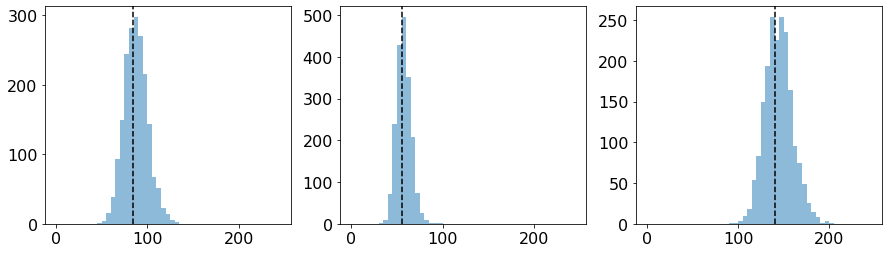

In [45]:
children = sorted([x for x in child_to_num_mat_crossovers.keys()])
num_crossovers_mat = np.array([child_to_num_mat_crossovers[x] for x in children])
num_crossovers_pat = np.array([child_to_num_pat_crossovers[x] for x in children])
famsize = np.array([child_to_famsize[x] for x in children])

bins = np.arange(0, 250, 5)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(np.clip(num_crossovers_mat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.axvline(42*2, color='black', linestyle='--')

plt.subplot(1, 3, 2)
plt.hist(np.clip(num_crossovers_pat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.axvline(28*2, color='black', linestyle='--')

plt.subplot(1, 3, 3)
plt.hist(np.clip(num_crossovers_mat[famsize==4]+num_crossovers_pat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==5]+num_crossovers_pat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==6]+num_crossovers_pat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize>6]+num_crossovers_pat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.axvline(28*2+42*2, color='black', linestyle='--')
plt.show()

In [46]:
print(42*2, 28*2, (28+42)*2)
print(np.median(num_crossovers_mat), np.median(num_crossovers_pat), np.median(num_crossovers_mat+num_crossovers_pat))

84 56 140
86.0 57.0 144.0


In [47]:
print(np.min(num_crossovers_mat), np.min(num_crossovers_pat))

48 34


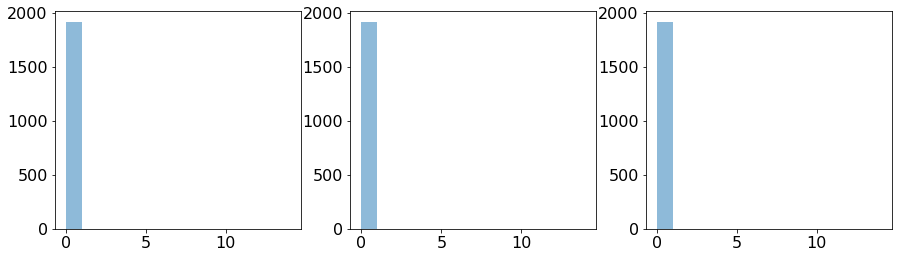

In [48]:
children = sorted([x for x in child_to_num_mat_crossovers.keys()])
num_crossovers_mat = np.array([child_to_num_matX_crossovers[x] for x in children])
num_crossovers_pat = np.array([child_to_num_patX_crossovers[x] for x in children])
famsize = np.array([child_to_famsize[x] for x in children])

bins = np.arange(0, 15)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.hist(np.clip(num_crossovers_mat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)

plt.subplot(1, 3, 2)
plt.hist(np.clip(num_crossovers_pat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_pat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)

plt.subplot(1, 3, 3)
plt.hist(np.clip(num_crossovers_mat[famsize==4]+num_crossovers_pat[famsize==4], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==5]+num_crossovers_pat[famsize==5], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize==6]+num_crossovers_pat[famsize==6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.hist(np.clip(num_crossovers_mat[famsize>6]+num_crossovers_pat[famsize>6], 0, bins[-2]), bins=bins, alpha=0.5)
plt.show()

In [49]:
chrom_to_cen, chrom_to_tel = defaultdict(list), defaultdict(list)
with open('../data/centromere%s.bed' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        try:
            chrom_to_cen[pieces[0][3:]].append((int(pieces[1]), int(pieces[2])))
        except:
            pass
            
with open('../data/telomere%s.bed' % assembly, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        try:
            chrom_to_tel[pieces[0][3:]].append((int(pieces[1]), int(pieces[2])))
        except:
            pass


In [50]:
crossover_lens = []
is_mat = []
is_complex = []
is_tel, is_cen = [], []
is_near_tel, is_near_cen = [], []
is_X = []
for child, crossovers in child_to_crossovers.items():
    for co in crossovers:
        length = co['end_pos']-co['start_pos']
        is_t, is_c = False, False
        is_nt, is_nc = False, False
        for s, e in chrom_to_tel[co['chrom']]:
            if min(e, co['end_pos'])-max(s, co['start_pos']) > 0:
                is_t = True
        for s, e in chrom_to_cen[co['chrom']]:
            if min(e, co['end_pos'])-max(s, co['start_pos']) > 0:
                is_c = True
        for s, e in chrom_to_tel[co['chrom']]:
            if min(e+10000000, co['end_pos'])-max(s-10000000, co['start_pos']) > 0:
                is_nt = True
        for s, e in chrom_to_cen[co['chrom']]:
            if min(e+10000000, co['end_pos'])-max(s-10000000, co['start_pos']) > 0:
                is_nc = True
                
        crossover_lens.append(length)
        is_mat.append(co['is_mat'])
        is_complex.append(co['is_complex'])
        is_X.append(co['chrom']=='X')
        is_tel.append(is_t)
        is_cen.append(is_c)
        is_near_tel.append(is_nt and not is_t)
        is_near_cen.append(is_nc and not is_c)
                
crossover_lens = np.array(crossover_lens)
is_mat = np.array(is_mat)
is_complex = np.array(is_complex)
is_tel = np.array(is_tel)
is_cen = np.array(is_cen)
is_near_tel = np.array(is_near_tel)
is_near_cen = np.array(is_near_cen)
is_X = np.array(is_X)
print(np.sum(is_tel), np.sum(is_cen), np.sum(is_near_tel), np.sum(is_near_cen), np.sum(is_X))

30766 13871 60511 37868 0


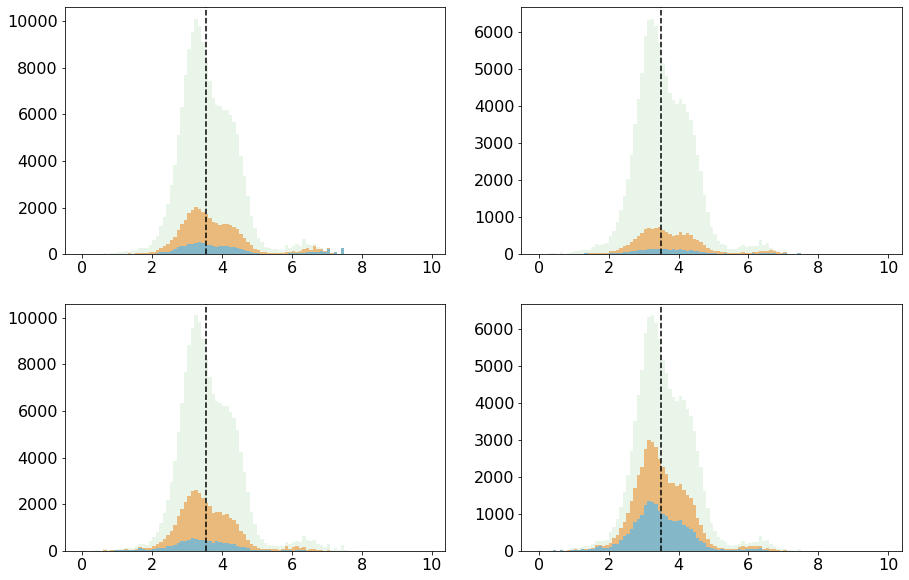

In [51]:
bins=np.arange(0, 10, 0.1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist([np.log10(crossover_lens[is_mat & is_cen & ~is_complex]),
          np.log10(crossover_lens[is_mat & is_near_cen & ~is_complex])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[is_mat & ~is_complex]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[is_mat])), color='black', linestyle='--')

plt.subplot(2, 2, 2)
plt.hist([np.log10(crossover_lens[~is_mat & is_cen & ~is_complex]),
          np.log10(crossover_lens[~is_mat & is_near_cen & ~is_complex])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[~is_mat & ~is_complex]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[~is_mat])), color='black', linestyle='--')

plt.subplot(2, 2, 3)
plt.hist([np.log10(crossover_lens[is_mat & is_tel & ~is_complex]),
          np.log10(crossover_lens[is_mat & is_near_tel & ~is_complex])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[is_mat & ~is_complex]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[is_mat])), color='black', linestyle='--')

plt.subplot(2, 2, 4)
plt.hist([np.log10(crossover_lens[~is_mat & is_tel & ~is_complex]),
          np.log10(crossover_lens[~is_mat & is_near_tel & ~is_complex])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[~is_mat & ~is_complex]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[~is_mat])), color='black', linestyle='--')

plt.show()

//anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


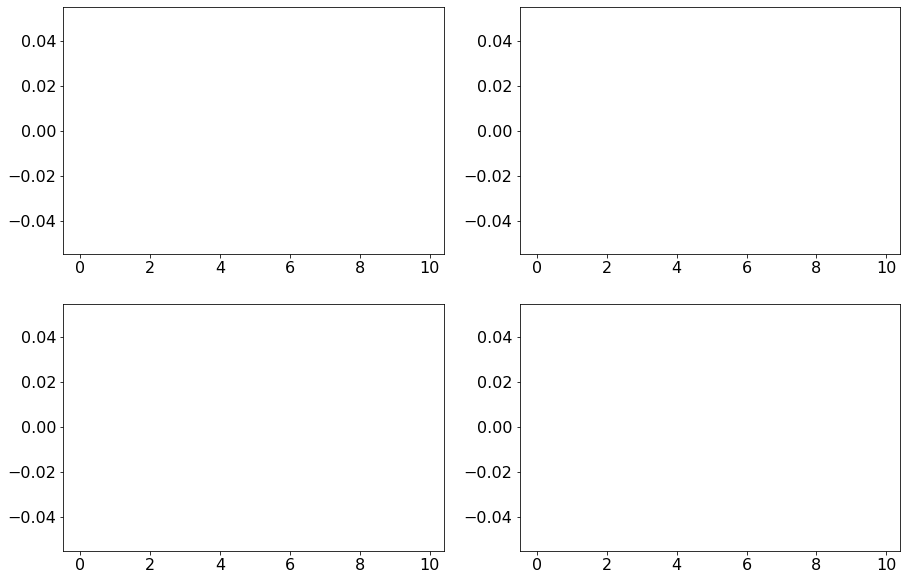

In [52]:
bins=np.arange(0, 10, 0.1)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist([np.log10(crossover_lens[is_mat & is_cen & ~is_complex & is_X]),
          np.log10(crossover_lens[is_mat & is_near_cen & ~is_complex & is_X])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[is_mat & ~is_complex & is_X]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[is_mat & is_X])), color='black', linestyle='--')

plt.subplot(2, 2, 2)
plt.hist([np.log10(crossover_lens[~is_mat & is_cen & ~is_complex & is_X]),
          np.log10(crossover_lens[~is_mat & is_near_cen & ~is_complex & is_X])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[~is_mat & ~is_complex & is_X]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[~is_mat & is_X])), color='black', linestyle='--')

plt.subplot(2, 2, 3)
plt.hist([np.log10(crossover_lens[is_mat & is_tel & ~is_complex & is_X]),
          np.log10(crossover_lens[is_mat & is_near_tel & ~is_complex & is_X])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[is_mat & ~is_complex & is_X]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[is_mat & is_X])), color='black', linestyle='--')

plt.subplot(2, 2, 4)
plt.hist([np.log10(crossover_lens[~is_mat & is_tel & ~is_complex & is_X]),
          np.log10(crossover_lens[~is_mat & is_near_tel & ~is_complex & is_X])], alpha=0.5, bins=bins, stacked=True)
plt.hist(np.log10(crossover_lens[~is_mat & ~is_complex & is_X]), alpha=0.1, bins=bins)
plt.axvline(np.log10(np.median(crossover_lens[~is_mat & is_X])), color='black', linestyle='--')

plt.show()

# Recombination hotspots

In [53]:
binsize=100000
positions = set()
for chrom in [str(x) for x in range(1, 23)] + ['X']:
    positions.update([(chrom, p) for p in np.arange(0, chrom_lengths[str(chrom)]+2*binsize, binsize)])
        
positions = sorted(positions)
chroms = [c for c, p in positions]
poss = np.array([p for c, p in positions])
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])


In [54]:
region_size = np.zeros((len(positions),), dtype=int)
indices = np.where([chroms[i]==chroms[i+1] for i in range(len(chroms)-1)])[0]
region_size[indices] = (poss[1:]-poss[:-1])[indices]

In [55]:
#print(chroms)
print(poss)
print(region_size)

[        0    100000    200000 ... 156000000 156100000 156200000]
[100000 100000 100000 ... 100000 100000      0]


In [56]:
recomb_mat = np.zeros((len(positions),))
recomb_pat = np.zeros((len(positions),))

already_included = set()
for child, crossovers in child_to_crossovers.items():
    if child[0] not in already_included and child[1] not in already_included:
        for co in crossovers:
            if co['is_mat']:
                start_index, end_index = pos_to_index[(co['chrom'], int(np.floor(co['start_pos']/binsize)*binsize))], pos_to_index[(co['chrom'], int(np.ceil(co['end_pos']/binsize)*binsize))]+1
                for index in range(start_index, end_index):
                    overlap = 0
                    if chroms[index]==co['chrom'] and chroms[index+1]==co['chrom']:
                        overlap = min(poss[index+1], co['end_pos'])-max(poss[index], co['start_pos'])
                    if overlap>0:
                        recomb_mat[index] += overlap/(co['end_pos']-co['start_pos'])
            if co['is_pat']:
                start_index, end_index = pos_to_index[(co['chrom'], int(np.floor(co['start_pos']/binsize)*binsize))], pos_to_index[(co['chrom'], int(np.ceil(co['end_pos']/binsize)*binsize))]+1
                for index in range(start_index, end_index):
                    overlap = 0
                    if chroms[index]==co['chrom'] and chroms[index+1]==co['chrom']:
                        overlap = min(poss[index+1], co['end_pos'])-max(poss[index], co['start_pos'])
                    if overlap>0:
                        recomb_pat[index] += overlap/(co['end_pos']-co['start_pos'])
        already_included.add(child[0])
        already_included.add(child[1])

recomb_mat = recomb_mat/len(already_included)
recomb_pat = recomb_pat/len(already_included)

recomb_mat_clipped = np.clip(recomb_mat, 3/len(already_included), None)
recomb_pat_clipped = np.clip(recomb_pat, 3/len(already_included), None) 


In [57]:
print(len(already_included))

3838


In [58]:
recomb_mat_kong = np.zeros((len(positions),))
recomb_pat_kong = np.zeros((len(positions),))

crossover_len_mat_kong, crossover_len_pat_kong = [], []
with open('../data/DECODE/DECODE_Recombination_Events_Maternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0][3:]
        start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
        start_index, end_index = pos_to_index[(chrom, int(np.floor(start_pos/binsize)*binsize))], pos_to_index[(chrom, int(np.ceil(end_pos/binsize)*binsize))]+1
        for index in range(start_index, end_index):
            overlap = 0
            if chroms[index]==chrom and chroms[index+1]==chrom:
                overlap = min(poss[index+1], end_pos)-max(poss[index], start_pos)
            if overlap>0:
                recomb_mat_kong[index] += overlap/(end_pos-start_pos)
        crossover_len_mat_kong.append(end_pos-start_pos)
with open('../data/DECODE/DECODE_Recombination_Events_Paternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        chrom = pieces[0][3:]
        start_pos, end_pos = [int(x) for x in pieces[1].split('-')]
        start_index, end_index = pos_to_index[(chrom, int(np.floor(start_pos/binsize)*binsize))], pos_to_index[(chrom, int(np.ceil(end_pos/binsize)*binsize))]+1
        for index in range(start_index, end_index):
            overlap = 0
            if chroms[index]==chrom and chroms[index+1]==chrom:
                overlap = min(poss[index+1], end_pos)-max(poss[index], start_pos)
            if overlap>0:
                recomb_pat_kong[index] += overlap/(end_pos-start_pos)
        crossover_len_pat_kong.append(end_pos-start_pos)
                    
recomb_mat_kong = recomb_mat_kong/41745 # from paper - the number of meioses
recomb_pat_kong = recomb_pat_kong/30184
 
recomb_mat_kong_clipped = np.clip(recomb_mat_kong, 3/41745, None) # from paper - the number of meioses
recomb_pat_kong_clipped = np.clip(recomb_pat_kong, 3/30184, None)
                          

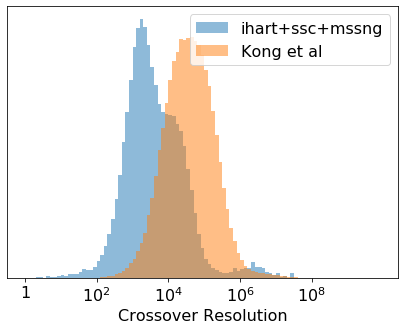

In [59]:
bins=np.arange(0, 10, 0.1)

plt.figure(figsize=(7, 5))
plt.rcParams.update({'font.size': 16})

plt.hist(np.log10(np.hstack((crossover_lens[~is_complex & is_mat], crossover_lens[~is_complex & ~is_mat]))), 
                  alpha=0.5, bins=bins, density=True, label='ihart+ssc+mssng')
plt.hist(np.log10(np.hstack((crossover_len_mat_kong, crossover_len_pat_kong))), 
                            alpha=0.5, bins=bins, density=True, label='Kong et al')
plt.legend()
plt.xticks(np.arange(0, 10, 2), ['1' if x==0 else '$10^{%d}$' % x for x in range(0, 10, 2)])
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('Crossover Resolution')

plt.show()

In [60]:
chr_lens = [chrom_lengths[str(x)] for x in [str(x) for x in range(1, 23)] + ['X']]
cum_chr_lengths = np.array([0, 0] + np.cumsum(chr_lens).tolist())
#xs = cum_chr_lengths[chroms] + poss

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


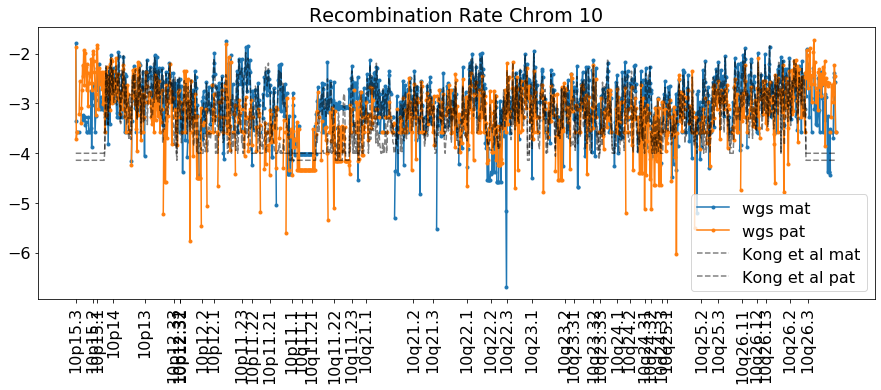

In [61]:
chrom = '10'
plt.figure(figsize=(15, 5))
indices = np.array([x==chrom for x in chroms])
p = plt.plot(poss[indices], np.log10(recomb_mat[indices]), label='wgs mat', marker='.')
q = plt.plot(poss[indices], np.log10(recomb_pat[indices]), label='wgs pat', marker='.')
plt.plot(poss[indices], np.log10(recomb_mat_kong_clipped[indices]), color='black', linestyle='--', label='Kong et al mat', alpha=0.5)#plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat_kong[(chroms==chrom)]), color='black', linestyle='--', label='Kong pat', alpha=0.5)
plt.plot(poss[indices], np.log10(recomb_pat_kong_clipped[indices]), color='black', linestyle='--', label='Kong et al pat', alpha=0.5)#plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat_kong[(chroms==chrom)]), color='black', linestyle='--', label='Kong pat', alpha=0.5)
plt.xticks([x[1] for x in cyto if x[0]=='chr%s' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%s' % chrom], rotation=90)
plt.legend()

plt.title('Recombination Rate Chrom %s' % chrom)
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


(0.8885575395249237, 0.0)
(0.8478957108366512, 0.0)


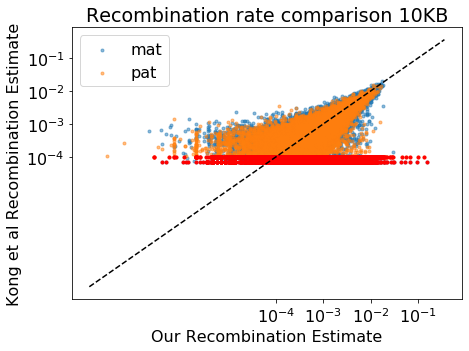

In [62]:
plt.figure(figsize=(7, 5))
plt.scatter(np.log10(recomb_mat), np.log10(recomb_mat_kong_clipped), alpha=0.5, marker='.', label='mat')
plt.scatter(np.log10(recomb_pat), np.log10(recomb_pat_kong_clipped), alpha=0.5, marker='.', label='pat')

indices = ~np.isclose(recomb_mat, np.min(recomb_mat)) & ~np.isclose(recomb_mat_kong_clipped, np.min(recomb_mat_kong_clipped))
plt.scatter(np.log10(recomb_mat[~indices]), np.log10(recomb_mat_kong_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_mat[indices], recomb_mat_kong_clipped[indices]))
indices = ~np.isclose(recomb_pat, np.min(recomb_pat)) & ~np.isclose(recomb_pat_kong_clipped, np.min(recomb_pat_kong_clipped))
plt.scatter(np.log10(recomb_pat[~indices]), np.log10(recomb_pat_kong_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_pat[indices], recomb_pat_kong_clipped[indices]))

plt.xlabel('Our Recombination Estimate')
plt.ylabel('Kong et al Recombination Estimate')
plt.xticks(np.arange(-4, 0), ['$10^{%d}$' % x for x in np.arange(-4, 0)])
plt.yticks(np.arange(-4, 0), ['$10^{%d}$' % x for x in np.arange(-4, 0)])
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.legend()
plt.title('Recombination rate comparison 10KB')
plt.show()

In [428]:
chrom, start_pos, end_pos = 10, 124500000, 127500000

recomb_mat_detailed = np.zeros((end_pos-start_pos,))
recomb_pat_detailed = np.zeros((end_pos-start_pos,))

for child, crossovers in child_to_crossovers.items():
    for co in crossovers:
        if (co['chrom'] == chrom) and (min(end_pos, co['end_pos'])-max(start_pos, co['start_pos'])>0):
            if co['is_mat']:
                start_index, end_index = np.clip(co['start_pos']-start_pos, 0, end_pos-start_pos), np.clip(co['end_pos']-start_pos, 0, end_pos-start_pos)
                recomb_mat_detailed[start_index:end_index] += (1/(co['end_pos']-co['start_pos']))
            if co['is_pat']:
                start_index, end_index = np.clip(co['start_pos']-start_pos, 0, end_pos-start_pos), np.clip(co['end_pos']-start_pos, 0, end_pos-start_pos)
                recomb_pat_detailed[start_index:end_index] += (1/(co['end_pos']-co['start_pos']))

recomb_mat_detailed = recomb_mat_detailed/len(already_included)
recomb_pat_detailed = recomb_pat_detailed/len(already_included)

#recomb_mat_detailed = np.clip(recomb_mat_detailed/len(already_included), 3/len(already_included), None)
#recomb_pat_detailed = np.clip(recomb_pat_detailed/len(already_included), 3/len(already_included), None) 


In [160]:
recomb_mat_kong_detailed = np.zeros((end_pos-start_pos,))
recomb_pat_kong_detailed = np.zeros((end_pos-start_pos,))

with open('../data/DECODE/DECODE_Recombination_Events_Maternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        co_chrom = pieces[0]
        co_start_pos, co_end_pos = [int(x) for x in pieces[1].split('-')]
        if co_chrom != 'chrX':
            co_chrom = int(co_chrom[3:])
            if (co_chrom == chrom) and (min(end_pos, co_end_pos)-max(start_pos, co_start_pos)>0):
                start_index, end_index = np.clip(co_start_pos-start_pos, 0, end_pos-start_pos), np.clip(co_end_pos-start_pos, 0, end_pos-start_pos)
                recomb_mat_kong_detailed[start_index:end_index] += (1/(co_end_pos-co_start_pos))
                
with open('../data/DECODE/DECODE_Recombination_Events_Paternal_01OCT2013_b%s.bed' % assembly, 'r') as f:
    next(f) # skip header
    for line in f:
        pieces = line.strip().split(':')
        co_chrom = pieces[0]
        co_start_pos, co_end_pos = [int(x) for x in pieces[1].split('-')]
        if co_chrom != 'chrX':
            co_chrom = int(co_chrom[3:])
            if (co_chrom == chrom) and (min(end_pos, co_end_pos)-max(start_pos, co_start_pos)>0):
                start_index, end_index = np.clip(co_start_pos-start_pos, 0, end_pos-start_pos), np.clip(co_end_pos-start_pos, 0, end_pos-start_pos)
                recomb_pat_kong_detailed[start_index:end_index] += (1/(co_end_pos-co_start_pos))
                
recomb_mat_kong_detailed = recomb_mat_kong_detailed/41745
recomb_pat_kong_detailed = recomb_pat_kong_detailed/30184


In [86]:
smooth_factor = 10000

plt.figure(figsize=(15, 5))
p = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_mat_detailed), label='ihart+ssc+mssng mat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_mat_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=p[0].get_color())
q = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_pat_detailed), label='ihart+ssc+mssng pat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_pat_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=q[0].get_color())

#plt.axhline(np.log10(np.sum(recomb_mat_detailed)), color=p[0].get_color(), alpha=0.5)
#plt.axhline(np.log10(np.sum(recomb_pat_detailed)), color=q[0].get_color(), alpha=0.5)

p = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_mat_kong_detailed), label='Kong mat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_mat_kong_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=p[0].get_color())
q = plt.plot(np.arange(start_pos, end_pos), np.log10(recomb_pat_kong_detailed), label='Kong pat', alpha=0.2)
plt.plot(np.arange(start_pos+(smooth_factor/2), end_pos-(smooth_factor/2)+1), np.convolve(np.log10(recomb_pat_kong_detailed), np.ones((smooth_factor,)), mode='valid')/smooth_factor, 
            color=q[0].get_color())

#plt.axhline(np.log10(np.sum(recomb_mat_kong_detailed)), color=p[0].get_color(), alpha=0.5)
#plt.axhline(np.log10(np.sum(recomb_pat_kong_detailed)), color=q[0].get_color(), alpha=0.5)

#plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
plt.legend()


#plt.xlim([70000, 90000])
plt.title('Recombination Rate')
plt.show()

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
//anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

(0.7572046326782637, 2.5487128497563523e-56)
(0.5808944416149358, 4.8080839575456844e-219)


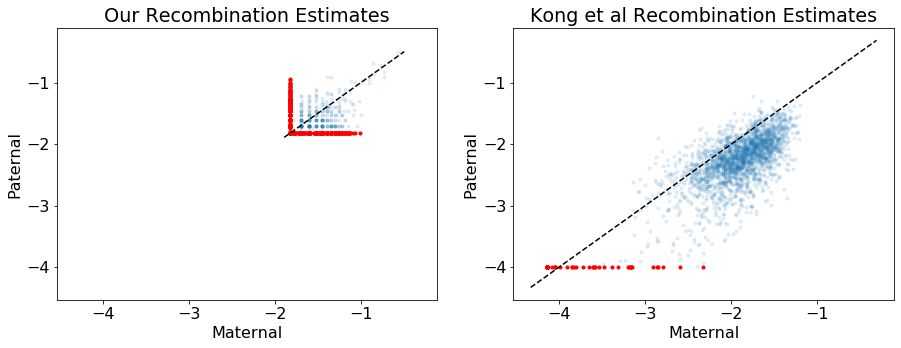

In [112]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(1, 2, 1)
plt.scatter(np.log10(recomb_mat_clipped), np.log10(recomb_pat_clipped), alpha=0.1, marker='.')

#indices = ~np.isclose(recomb_mat_kong_clipped, np.min(recomb_mat_kong_clipped)) & ~np.isclose(recomb_pat_kong_clipped, np.min(recomb_pat_kong_clipped))
#plt.scatter(np.log10(recomb_mat_clipped[~indices]), np.log10(recomb_pat_clipped[~indices]), marker='.', alpha=0.2)
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

indices = ~np.isclose(recomb_mat_clipped, np.min(recomb_mat_clipped)) & ~np.isclose(recomb_pat_clipped, np.min(recomb_pat_clipped))
plt.scatter(np.log10(recomb_mat_clipped[~indices]), np.log10(recomb_pat_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_mat_clipped[indices], recomb_pat_clipped[indices]))

plt.title('Our Recombination Estimates')
plt.xlabel('Maternal')
plt.ylabel('Paternal')

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.scatter(np.log10(recomb_mat_kong_clipped), np.log10(recomb_pat_kong_clipped), alpha=0.1, marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')

indices = ~np.isclose(recomb_mat_kong_clipped, np.min(recomb_mat_kong_clipped)) & ~np.isclose(recomb_pat_kong_clipped, np.min(recomb_pat_kong_clipped))
plt.scatter(np.log10(recomb_mat_kong_clipped[~indices]), np.log10(recomb_pat_kong_clipped[~indices]), marker='.', color='red')
print(stats.pearsonr(recomb_mat_kong_clipped[indices], recomb_pat_kong_clipped[indices]))

plt.title('Kong et al Recombination Estimates')
plt.xlabel('Maternal')
plt.ylabel('Paternal')

plt.show()

mat params (3.7098125704652163, 1.1285556134588521, 0.23222652148665007)
pat params (13.960050574313115, 0.3143661373713137, 0.13754863440265547)


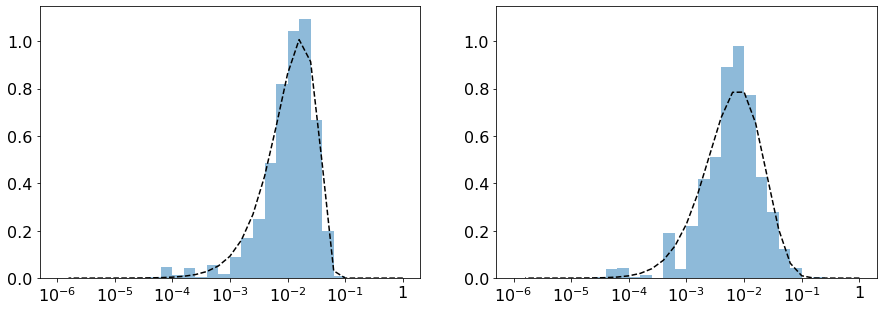

In [430]:
plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.hist(np.log10(recomb_mat[recomb_mat != 0]), alpha=0.5, bins=np.arange(-6, 0, 0.2), density=True)
indices = ~np.isclose(recomb_mat[recomb_mat != 0], np.min(recomb_mat[recomb_mat != 0]))
params = stats.gamma.fit(-np.log10(recomb_mat[recomb_mat != 0][indices]))
print('mat params', params)
plt.plot(np.arange(0, -6, -0.2), stats.gamma.pdf(np.arange(0, 6, 0.2), *params), color='black', linestyle='--')

#plt.hist(np.log10(recomb_mat_kong), alpha=0.5, bins=np.arange(-6, 0, 0.1), density=True)
#indices = ~np.isclose(recomb_mat_kong, np.min(recomb_mat_kong))
#params = stats.gamma.fit(-np.log10(recomb_mat_kong[indices]))
#print(params)
#plt.plot(np.arange(0, -6, -0.1), stats.gamma.pdf(np.arange(0, 6, 0.1), *stats.gamma.fit(-np.log10(recomb_mat_kong[indices]))), color='black', linestyle='--')
#
plt.xticks(np.arange(-6, 1), ['1' if x==0 else '$10^{%d}$' % x for x in np.arange(-6, 1)])

plt.subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.hist(np.log10(recomb_pat[recomb_pat!=0]), alpha=0.5, bins=np.arange(-6, 0, 0.2), density=True)
indices = ~np.isclose(recomb_pat, np.min(recomb_pat))
params = stats.gamma.fit(-np.log10(recomb_pat[indices]))
print('pat params', params)
plt.plot(np.arange(0, -6, -0.2), stats.gamma.pdf(np.arange(0, 6, 0.2), *params), color='black', linestyle='--')

#plt.hist(np.log10(recomb_pat_kong[recomb_pat_kong!=0]), alpha=0.5, bins=np.arange(-6, 0, 0.1), density=True)
#indices = ~np.isclose(recomb_pat_kong, np.min(recomb_pat_kong))
#params = stats.gamma.fit(-np.log10(recomb_pat_kong[indices]))
#print(params)
#plt.plot(np.arange(0, -6, -0.1), stats.gamma.pdf(np.arange(0, 6, 0.1), *stats.gamma.fit(-np.log10(recomb_pat_kong[indices]))), color='black', linestyle='--')

plt.xticks(np.arange(-6, 1), ['1' if x==0 else '$10^{%d}$' % x for x in np.arange(-6, 1)])
plt.show()

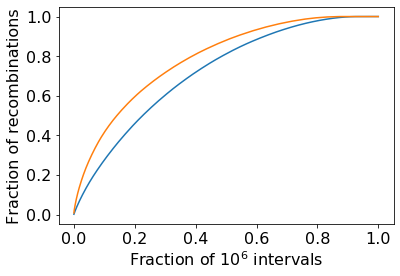

In [431]:
ordered_recomb_mat = np.flip(recomb_mat[np.argsort(recomb_mat)]*len(already_included))
ordered_recomb_pat = np.flip(recomb_pat[np.argsort(recomb_pat)]*len(already_included))

num_mat_recomb = np.sum(recomb_mat*len(already_included))
plt.plot(np.arange(0, 1, 1/len(ordered_recomb_mat))[:len(ordered_recomb_mat)], 
         np.cumsum(ordered_recomb_mat)/num_mat_recomb)

num_pat_recomb = np.sum(recomb_pat*len(already_included))
plt.plot(np.arange(0, 1, 1/len(ordered_recomb_pat))[:len(ordered_recomb_pat)],
         np.cumsum(ordered_recomb_pat)/num_pat_recomb)
plt.xlabel('Fraction of $10^{%d}$ intervals' % np.log10(binsize))
plt.ylabel('Fraction of recombinations')
plt.show()

# Learning hotspots and coldspots

In [34]:
from sklearn.linear_model import LogisticRegression
import scipy.sparse as sparse
import cvxpy as cp


In [35]:
all_positions_mat = set()
num_crossovers_mat = 0
all_positions_pat = set()
num_crossovers_pat = 0
for child, crossovers in child_to_crossovers.items():
    for co in crossovers:
        if co['is_mat']:
            all_positions_mat.add((co['chrom'], co['start_pos']))
            all_positions_mat.add((co['chrom'], co['end_pos']))
            num_crossovers_mat += 1
        if co['is_pat']:
            all_positions_pat.add((co['chrom'], co['start_pos']))
            all_positions_pat.add((co['chrom'], co['end_pos']))
            num_crossovers_pat += 1

for chrom in range(1, 23):
    all_positions_mat.update([(chrom, p) for p in np.arange(0, chrom_lengths[str(chrom)]+1000000, 1000000)])
    all_positions_pat.update([(chrom, p) for p in np.arange(0, chrom_lengths[str(chrom)]+1000000, 1000000)])
        
all_positions = sorted(all_positions_mat | all_positions_pat)
pos_to_index = dict([(x, i) for i, x in enumerate(all_positions)])
print('num_crossovers', num_crossovers_mat+num_crossovers_pat, 'positions', len(all_positions))

all_positions_mat = sorted(all_positions_mat)
pos_to_index_mat = dict([(x, i) for i, x in enumerate(all_positions_mat)])
print('num_crossovers', num_crossovers_mat, 'positions', len(all_positions_mat))

all_positions_pat = sorted(all_positions_pat)
pos_to_index_pat = dict([(x, i) for i, x in enumerate(all_positions_pat)])
print('num_crossovers', num_crossovers_pat, 'positions', len(all_positions_pat))



num_crossovers 442209 positions 272415
num_crossovers 268959 positions 213705
num_crossovers 173250 positions 159169


In [36]:
lengths_mat = np.array([0 if all_positions_mat[i][0] != all_positions_mat[i+1][0] else all_positions_mat[i+1][1]-all_positions_mat[i][1] for i in range(len(all_positions_mat)-1)])
lengths_pat = np.array([0 if all_positions_pat[i][0] != all_positions_pat[i+1][0] else all_positions_pat[i+1][1]-all_positions_pat[i][1] for i in range(len(all_positions_pat)-1)])
lengths = np.array([0 if all_positions[i][0] != all_positions[i+1][0] else all_positions[i+1][1]-all_positions[i][1] for i in range(len(all_positions)-1)])
    
           

In [37]:
all_positions_mat, pos_to_index_mat, lengths_mat = all_positions, pos_to_index, lengths
all_positions_pat, pos_to_index_pat, lengths_pat = all_positions, pos_to_index, lengths

In [38]:
X_mat, X_pat = [], []
n_mat, n_pat = len(all_positions_mat)-1, len(all_positions_pat)-1
neg_count_mat = np.zeros((n_mat, 1), dtype=int)
neg_count_pat = np.zeros((n_pat, 1), dtype=int)

for child, crossovers in child_to_crossovers.items():
    mat_crossovers = [co for co in crossovers if co['is_mat']]
    data, row_ind, col_ind = [], [], []
    row_i = 0
    for co in mat_crossovers:
        start_index, end_index = pos_to_index_mat[(co['chrom'], co['start_pos'])], pos_to_index_mat[(co['chrom'], co['end_pos'])]
        data.extend([1,]*(end_index-start_index))
        row_ind.extend([row_i,]*(end_index-start_index))
        col_ind.extend(range(start_index, end_index))
        row_i += 1
    X_mat.append(sparse.csr_matrix((data, (row_ind, col_ind)), shape=(len(mat_crossovers), n_mat)))
    neg_count_mat += 2-X_mat[-1].sum(axis=0).T
        
    pat_crossovers = [co for co in crossovers if co['is_pat']]
    data, row_ind, col_ind = [], [], []
    row_i = 0
    for co in pat_crossovers:
        start_index, end_index = pos_to_index_pat[(co['chrom'], co['start_pos'])], pos_to_index_pat[(co['chrom'], co['end_pos'])]
        data.extend([1,]*(end_index-start_index))
        row_ind.extend([row_i,]*(end_index-start_index))
        col_ind.extend(range(start_index, end_index))
        row_i += 1
    X_pat.append(sparse.csr_matrix((data, (row_ind, col_ind)), shape=(len(pat_crossovers), n_pat)))
    neg_count_pat += 2-X_pat[-1].sum(axis=0).T
        
X_mat = sparse.vstack(X_mat) 
X_pat = sparse.vstack(X_pat)

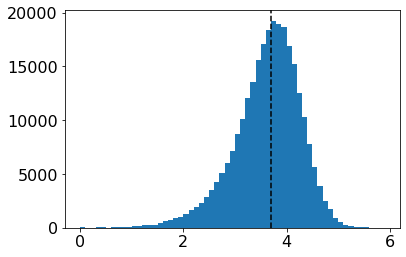

In [39]:
plt.hist(np.log10(lengths[lengths != 0]), bins=np.arange(0, 6, 0.1))
plt.axvline(np.median(np.log10(lengths[lengths != 0])), color='black', linestyle='--')
plt.show()

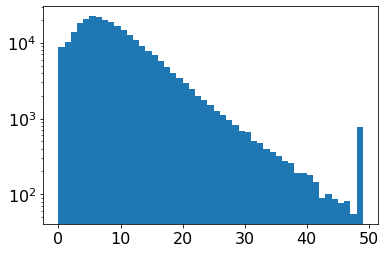

In [40]:
plt.hist(np.clip(X_mat.sum(axis=0).A.flatten(), 0, 49), bins=np.arange(0, 50), log=True)
plt.show()

In [41]:
import gurobipy
import cvxpy as cp
import mosek

def estimate_recombination_rates(X, neg_count, lengths, positions, n):
    print('Estimating...', X.shape, neg_count.shape)
    lamb = 1000

    # cvxpy
    num_crossovers = X.sum(axis=0).A.flatten()
    
    p = cp.Variable(X.shape[1])
    
    expr = cp.sum(cp.log(X@p))/n #+ ((neg_count.T)@cp.log(1-p))/n
    
    # minimize difference within chromosomes
    current_chrom = positions[0][0]
    current_chrom_start = 0
    for i in range(1, len(positions)):
        if positions[i][0] != current_chrom:
            expr -= cp.tv(lamb*p[current_chrom_start:i]/lengths[current_chrom_start:i])
            current_chrom, current_chrom_start = positions[i][0], i
    expr -= cp.tv(lamb*p[current_chrom_start:i]/lengths[current_chrom_start:i])
            
    prob = cp.Problem(cp.Maximize(expr), [p >= 0, p <= 1, cp.sum(p)==1])
    #result = prob.solve(solver='MOSEK', mosek_params={'MSK_IPAR_INTPNT_MAX_ITERATIONS': 300}, verbose=True)
    result = prob.solve(solver='GUROBI', max_iters=200, verbose=True)
    #result = prob.solve(solver='ECOS', max_iters=200, verbose=True)
    print(prob.status)

    ps = np.clip([v for v in p.value], 0, 1)

    if prob.status != 'optimal' and prob.status != 'optimal_inaccurate':
        raise Error('Parameters not fully estimated.')
    return ps

#ps_mat = estimate_recombination_rates(X_mat, y_mat, lengths_mat, len(already_included))
#ps_pat = estimate_recombination_rates(X_pat, y_pat, lengths_pat, len(already_included))
ps_mat = estimate_recombination_rates(X_mat, neg_count_mat, lengths_mat, all_positions_mat, n_mat)
ps_pat = estimate_recombination_rates(X_pat, neg_count_pat, lengths_pat, all_positions_pat, n_pat)


Estimating... (268959, 272414) (272414, 1)


SolverError: Either candidate conic solvers (['GUROBI']) do not support the cones output by the problem (ExpCone, NonNeg, Zero), or there are not enough constraints in the problem.

In [ ]:
print(np.sum(ps_mat))
print(ps_mat)

In [ ]:
plt.figure(figsize=(15, 5))
plt.scatter([cum_chr_lengths[c]+p for c, p in all_positions_mat[:-1]], np.log10(ps_mat) - np.log10(lengths_mat), marker='.', alpha=0.1)
plt.scatter([cum_chr_lengths[c]+p for c, p in all_positions_pat[:-1]], np.log10(ps_pat) - np.log10(lengths_pat), marker='.', alpha=0.1)
#plt.plot(xs, np.log10(recomb_mat_clipped), label='ihart+ssc+mssng mat', alpha=0.1)
plt.xticks(cum_chr_lengths[1:-1], range(1, 23), rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(12, 10))

#indices = (ps_mat>0) | (ps_pat>0)
#plt.hexbin(np.clip(np.log10(ps_mat), -10, 0), 
#            np.clip(np.log10(ps_pat), -10, 0),
#          gridsize=100, bins='log')#, marker='.', alpha=0.1)

plt.hexbin(np.clip(np.log10(ps_mat) - np.log10(lengths), -20, 0), 
            np.clip(np.log10(ps_pat) - np.log10(lengths), -20, 0),
          gridsize=100, bins='log')#, marker='.', alpha=0.1)
plt.colorbar()

indices = np.abs((np.log10(ps_mat) - np.log10(lengths)) - (np.log10(ps_pat) - np.log10(lengths)))>2
#plt.scatter(np.clip(np.log10(ps_mat) - np.log10(lengths), -15, 0)[indices], 
#            np.clip(np.log10(ps_pat) - np.log10(lengths), -15, 0)[indices], marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
#plt.xlim([-7, None])
#plt.ylim([-7, None])
plt.show()

In [ ]:
print(np.sum((np.log10(ps_mat) - np.log10(lengths) > -10) & (np.log10(ps_pat) - np.log10(lengths) > -10)))
print(np.sum((np.log10(ps_mat) - np.log10(lengths) > -10) & (np.log10(ps_pat) - np.log10(lengths) < -10)))
print(np.sum((np.log10(ps_mat) - np.log10(lengths) < -10) & (np.log10(ps_pat) - np.log10(lengths) > -10)))

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(np.log10(ps_mat)[ps_pat > 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))
plt.hist(np.log10(ps_mat)[ps_pat < 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))

plt.subplot(1, 2, 2)
plt.hist(np.log10(ps_pat)[ps_mat > 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))
plt.hist(np.log10(ps_pat)[ps_mat < 10**-10], alpha=0.5, bins=np.arange(-10, 0, 0.1))
plt.show()

In [ ]:
plt.hist(np.log10(ps_mat), bins=np.arange(-15, 0, 0.1), alpha=0.5)
plt.hist(np.log10(ps_pat), bins=np.arange(-15, 0, 0.1), alpha=0.5)
#plt.axvline(np.log10(p_baseline), color='black', linestyle='--')
plt.show()

In [ ]:
plt.hist(np.log10(ps_mat) - np.log10(lengths_mat), bins=np.arange(-14, 0, 0.1), alpha=0.5)
plt.hist(np.log10(ps_pat) - np.log10(lengths_pat), bins=np.arange(-14, 0, 0.1), alpha=0.5)
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

bins = np.arange(-25, 0, 0.05)
a = np.zeros((len(bins),))
for d, l in zip(np.digitize(np.log10(ps_mat)-np.log10(lengths_mat), bins), lengths_mat):
    if d>0:
        a[d-1] += l
plt.plot(bins, a, alpha=0.5)
#print(a)

b = np.zeros((len(bins),))
for d, l in zip(np.digitize(np.log10(ps_pat)-np.log10(lengths_pat), bins), lengths_pat):
    if d>0:
        b[d-1] += l
plt.plot(bins, b, alpha=0.5)
#plt.xlim(-10, -5)
#plt.ylim(0, 10**7.5)
#print(b)

plt.show()

print(np.sum(a[np.where(bins>-10)[0]])/np.sum(lengths_mat))
print(np.sum(b[np.where(bins>-10)[0]])/np.sum(lengths_pat))


In [ ]:
p_baseline = 10**-10

is_hotspot_mat = ps_mat>(lengths_mat*p_baseline)
is_coldspot_mat = ps_pat>(lengths_pat*p_baseline)

print('hotspots mat')
print(np.sum(is_hotspot_mat), np.sum(is_hotspot_mat)/ps_mat.shape[0])
print(np.sum(lengths_mat*is_hotspot_mat)/np.sum(lengths_mat))

print('coldspots mat')
print(np.sum(is_coldspot_mat), np.sum(is_coldspot_mat)/ps_mat.shape[0])
print(np.sum(lengths_mat*is_coldspot_mat)/np.sum(lengths_mat))

is_hotspot_pat = ~np.isclose(ps_pat, (lengths_pat*p_baseline)) & (ps_pat>(lengths_pat*p_baseline))
is_coldspot_pat = ~np.isclose(ps_pat, (lengths_pat*p_baseline)) & (ps_pat<(lengths_pat*p_baseline))

print('hotspots pat')
print(np.sum(is_hotspot_pat), np.sum(is_hotspot_pat)/ps_pat.shape[0])
print(np.sum(lengths_pat*is_hotspot_pat)/np.sum(lengths_pat))

print('coldspots pat')
print(np.sum(is_coldspot_pat), np.sum(is_coldspot_pat)/ps_pat.shape[0])
print(np.sum(lengths_pat*is_coldspot_pat)/np.sum(lengths_pat))

In [ ]:
hotspot_start_mat = np.where(~is_hotspot_mat[:-1] & is_hotspot_mat[1:])[0]+1
hotspot_end_mat = np.where(is_hotspot_mat[:-1] & ~is_hotspot_mat[1:])[0]+1
hotspot_lengths_mat = [np.sum(lengths_mat[s:e]) for s, e in zip(hotspot_start_mat, hotspot_end_mat)]

hotspot_start_pat = np.where(~is_hotspot_pat[:-1] & is_hotspot_pat[1:])[0]+1
hotspot_end_pat = np.where(is_hotspot_pat[:-1] & ~is_hotspot_pat[1:])[0]+1
hotspot_lengths_pat = [np.sum(lengths_pat[s:e]) for s, e in zip(hotspot_start_pat, hotspot_end_pat)]

plt.hist(np.log10(hotspot_lengths_mat), bins=np.arange(0, 7, 0.1), alpha=0.5, density=True)
plt.hist(np.log10(hotspot_lengths_pat), bins=np.arange(0, 7, 0.1), alpha=0.5, density=True)
#plt.hist(np.log10(lengths), bins=np.arange(0, 7, 0.1), alpha=0.5, density=True)
plt.show()

In [ ]:
print(np.median(hotspot_lengths_mat))
print(np.median(hotspot_lengths_pat))

In [ ]:
interval_pos_mat, interval_pos_pat = [], []
interval_chrom_mat, interval_chrom_pat = [], []
data, row_ind, col_ind = [], [], []
row_i = 0
for chrom in range(1, 23):
    for p in np.arange(0, chrom_lengths[str(chrom)]+2000000, 1000000):
        if (chrom, p+1000000) in pos_to_index_mat:
            start_index, end_index = pos_to_index_mat[(chrom, p)], pos_to_index_mat[(chrom, p+1000000)]
            data.extend([1,]*(end_index-start_index))
            row_ind.extend([row_i,]*(end_index-start_index))
            col_ind.extend(range(start_index, end_index))
        row_i += 1
        interval_pos_mat.append(p)
        interval_chrom_mat.append(chrom)

test_intervals_mat = sparse.csr_matrix((data, (row_ind, col_ind)), shape=(row_i, n_mat))
interval_pos_mat = np.array(interval_pos_mat)
interval_chrom_mat = np.array(interval_chrom_mat)

data, row_ind, col_ind = [], [], []
row_i = 0
for chrom in range(1, 23):
    for p in np.arange(0, chrom_lengths[str(chrom)]+2000000, 1000000):
        if (chrom, p+1000000) in pos_to_index_pat:
            start_index, end_index = pos_to_index_pat[(chrom, p)], pos_to_index_pat[(chrom, p+1000000)]
            data.extend([1,]*(end_index-start_index))
            row_ind.extend([row_i,]*(end_index-start_index))
            col_ind.extend(range(start_index, end_index))
        row_i += 1
        interval_pos_pat.append(p)
        interval_chrom_pat.append(chrom)
            
test_intervals_pat = sparse.csr_matrix((data, (row_ind, col_ind)), shape=(row_i, n_pat))
interval_pos_pat = np.array(interval_pos_pat)
interval_chrom_pat = np.array(interval_chrom_pat)

In [ ]:
pred_mat = test_intervals_mat.dot(ps_mat)
pred_pat = test_intervals_pat.dot(ps_pat)



In [ ]:
chrom = 20

plt.figure(figsize=(15, 5))
indices = [c==chrom for c, p in all_positions_mat[:-1]]
p = plt.plot(np.repeat([p for c, p in all_positions_mat[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_mat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
indices = [c==chrom for c, p in all_positions_pat[:-1]]
q = plt.plot(np.repeat([p for c, p in all_positions_pat[:-1] if c==chrom], 2)[1:], 
         np.repeat((np.log10(ps_pat)-np.log10(lengths))[indices], 2)[:-1], marker='.', alpha=0.5)
#plt.plot(interval_pos_mat[interval_chrom==chrom], np.log10(pred_mat[interval_chrom_mat==chrom]), label='ihart+ssc+mssng mat')
#plt.plot(interval_pos_pat[interval_chrom==chrom], np.log10(pred_pat[interval_chrom_mat==chrom]), label='ihart+ssc+mssng pat')
#plt.plot(poss[(chroms==chrom)], np.log10(recomb_mat[(chroms==chrom)]), linestyle='--')
#plt.plot(poss[(chroms==chrom)], np.log10(recomb_pat[(chroms==chrom)]), linestyle='--')
#plt.axhline(np.log10(np.median(ps_mat/lengths_mat)), color=p[0].get_color(), linestyle='--')
#plt.axhline(np.log10(np.median(ps_pat/lengths_pat)), color=q[0].get_color(), linestyle='--')
plt.axhline(-10, color='black', linestyle='--')

plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)

#plt.xlim([162790000, 162910000])
plt.xlim([5000000, 6000000])
plt.show()


In [ ]:
np.save('../recombination_rate/wgs.lengths', lengths)

In [ ]:
import pandas as pd

chrom = 20
indices = [c==chrom for c, p in all_positions_mat[:-1]]

s1 = pd.Series((np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))<2))

plt.figure(figsize=(15, 5))
plt.plot([p for c, p in all_positions_mat[:-1] if c==chrom], s1.rolling(100).mean()[indices])
plt.scatter([p for c, p in all_positions_mat[:-1] if c==chrom], 
         ((np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))>2) & (np.log10(ps_mat)-np.log10(lengths_mat) > np.log10(ps_pat)-np.log10(lengths_pat)))[indices], 
            marker='.', alpha=0.1)
plt.scatter([p for c, p in all_positions_mat[:-1] if c==chrom], 
         ((np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))>2) & (np.log10(ps_mat)-np.log10(lengths_mat) < np.log10(ps_pat)-np.log10(lengths_pat)))[indices], 
            marker='.', alpha=0.1)
plt.scatter([p for c, p in all_positions_mat[:-1] if c==chrom], 
         (np.abs((np.log10(ps_mat)-np.log10(lengths_mat))-(np.log10(ps_pat)-np.log10(lengths_pat)))<2)[indices], 
            marker='.', alpha=0.1)

plt.xticks([x[1] for x in cyto if x[0]=='chr%d' % chrom], [str(chrom) + x[3] for x in cyto if x[0]=='chr%d' % chrom], rotation=90)
#plt.xlim([0, 5000000])
#plt.xlim([15000000, 30000000])
#plt.xlim([30000000, 45000000])
#plt.xlim([45000000, 60000000])

plt.show()

In [ ]:
print(len(already_included))

In [ ]:
indices = np.where((X_mat.sum(axis=0)+X_pat.sum(axis=0)>0) & (lengths<10**4))[1]
start_interval_chrom = np.array([all_positions[i][0] for i in indices])
start_interval_pos = np.array([all_positions[i][1] for i in indices])
end_interval_chrom = np.array([all_positions[i+1][0] for i in indices])
end_interval_pos = np.array([all_positions[i+1][1] for i in indices])


In [ ]:
plt.hist(np.log10(np.clip(end_interval_pos-start_interval_pos, 1, None)),
        bins=np.arange(0, 6, 0.1))
plt.show()

In [ ]:
print(np.sum(end_interval_pos-start_interval_pos)/np.sum(lengths))

In [ ]:
assert np.all([chrom_start==chrom_end for (chrom_start, pos_start), (chrom_end, pos_end) in zip(start_interval, end_interval)])



In [ ]:
import numpy as np
from scipy import sparse
import scipy.stats
import random
from collections import defaultdict
from os import listdir
import json

chrom = '22'
data_dir = '../../DATA/mssng/genotypes'

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.npz' in f], key=lambda x: int(x.split('.')[2]))
coord_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.coordinates.npy' in f], key=lambda x: int(x.split('.')[2]))
af_files = sorted([f for f in listdir(data_dir) if ('chr.%s.' % chrom) in f and 'gen.af.npy' in f], key=lambda x: int(x.split('.')[2]))
sample_file = '%s/samples.json' % data_dir


snp_positions = []
for gen_file, coord_file, af_file in zip(gen_files, coord_files, af_files):
	coords = np.load('%s/%s' % (data_dir, coord_file))
	if coords.shape[0]>0:
		snp_positions.append(coords[:, 1])

In [477]:
snp_positions = np.hstack(snp_positions)

In [478]:
variants = []
for (chrom_start, pos_start), (chrom_end, pos_end) in zip(start_interval, end_interval):
    if chrom_start == 22:
        variants.append(np.sum((snp_positions >= pos_start) & (snp_positions <= pos_end)))
        

In [479]:
variants = np.array(variants)
print(np.sum((variants>0) & (variants<100))/len(variants))

0.6068824730242053


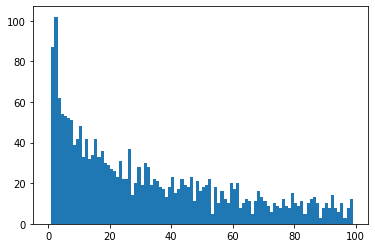

In [480]:
plt.hist(variants, bins=np.arange(0, 100))
plt.show()

# Differentiating COs and NCOs

In [472]:
from collections import namedtuple
import os
import itertools

In [473]:
sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped('../../DATA/ihart.ms2/ihart.ped.quads.ped')


In [484]:
matpat_to_intervals = defaultdict(list)
matpat_to_intervalsX = defaultdict(list)
matpat_to_intervalsX_par = defaultdict(list)

par1_end = 2781479+1000000
par2_start = 155701383-1000000

for (sib1, sib2), cos in child_to_crossovers.items():
    if sample_to_sex[sib1]=='1' or sample_to_sex[sib2]=='1':
        for (chrom, is_mat), ccos in itertools.groupby([x for x in cos if (not x['is_complex'])], lambda x: (x['chrom'], x['is_mat'])):
            ccos = list(ccos)
            ccos_pos = np.array([1] + [(x['start_pos']+x['end_pos'])/2 for x in ccos] + [chrom_lengths[chrom]])
            
            matpat_to_intervals[is_mat].extend(np.minimum(ccos_pos[1:-1]-ccos_pos[:-2], ccos_pos[2:]-ccos_pos[1:-1]))
            if chrom == 'X':
                is_in_par = (ccos_pos <= par1_end) | (ccos_pos >= par2_start)
                matpat_to_intervalsX[is_mat].extend((np.minimum(ccos_pos[1:-1]-ccos_pos[:-2], ccos_pos[2:]-ccos_pos[1:-1]))[~is_in_par[1:-1]])
                matpat_to_intervalsX_par[is_mat].extend((np.minimum(ccos_pos[1:-1]-ccos_pos[:-2], ccos_pos[2:]-ccos_pos[1:-1]))[is_in_par[1:-1]])


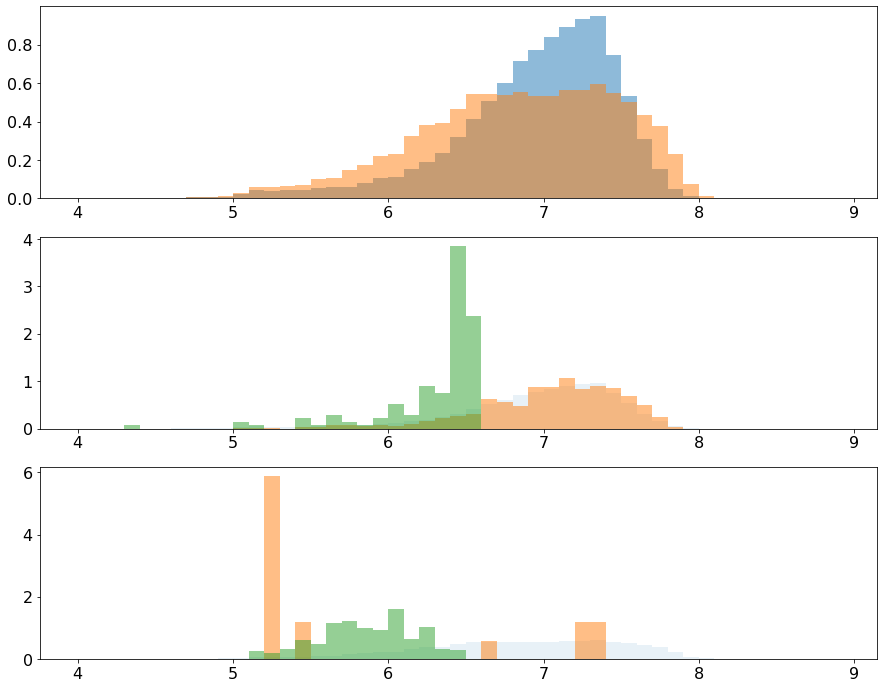

In [485]:
plt.figure(figsize=(15, 12))
plt.subplot(3, 1, 1)

plt.hist(np.log10(matpat_to_intervals[True]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)
plt.hist(np.log10(matpat_to_intervals[False]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)
plt.axvline()

plt.subplot(3, 1, 2)
plt.hist(np.log10(matpat_to_intervals[True]), alpha=0.1, bins=np.arange(4, 9, 0.1), density=True)
plt.hist(np.log10(matpat_to_intervalsX[True]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)
plt.hist(np.log10(matpat_to_intervalsX_par[True]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)

plt.subplot(3, 1, 3)
plt.hist(np.log10(matpat_to_intervals[False]), alpha=0.1, bins=np.arange(4, 9, 0.1), density=True)
plt.hist(np.log10(matpat_to_intervalsX[False]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)
plt.hist(np.log10(matpat_to_intervalsX_par[False]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)

plt.show()

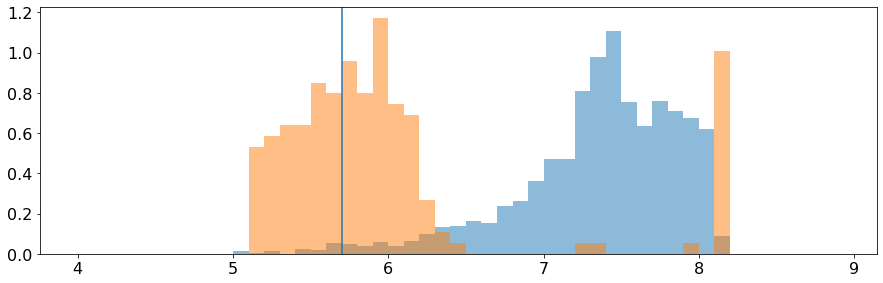

In [476]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
#plt.hist(np.log10(dataset_chrom_matpat_to_intervals[('ihart', 1, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
#plt.hist(np.log10(dataset_chrom_matpat_to_intervals[('mssng', 1, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)

plt.hist(np.log10(matpat_to_intervalsX[True]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)
plt.hist(np.log10(matpat_to_intervalsX[False]), alpha=0.5, bins=np.arange(4, 9, 0.1), density=True)
plt.axvline(np.log10(500000))
plt.show()

In [ ]:
print([])

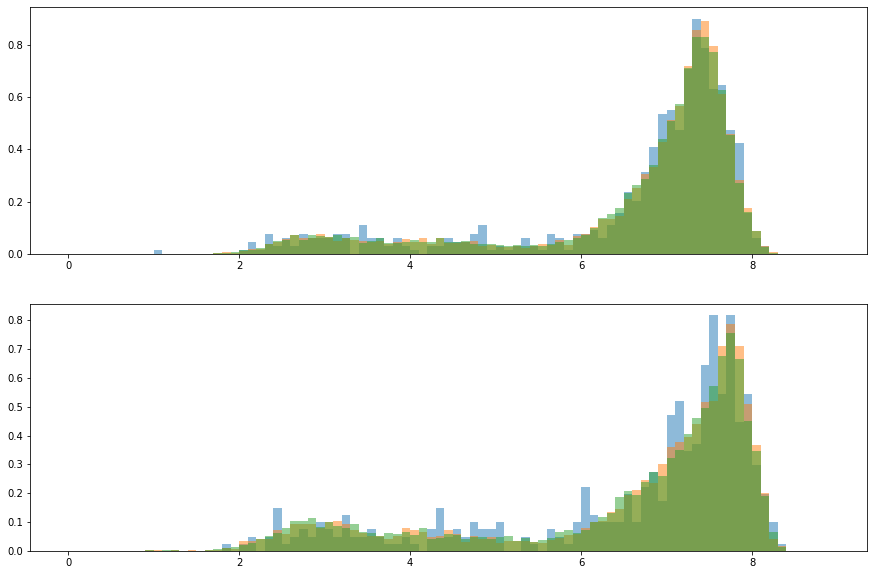

In [229]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 0, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 1, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 2, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)

plt.subplot(2, 1, 2)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 0, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 1, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 2, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)

plt.show()

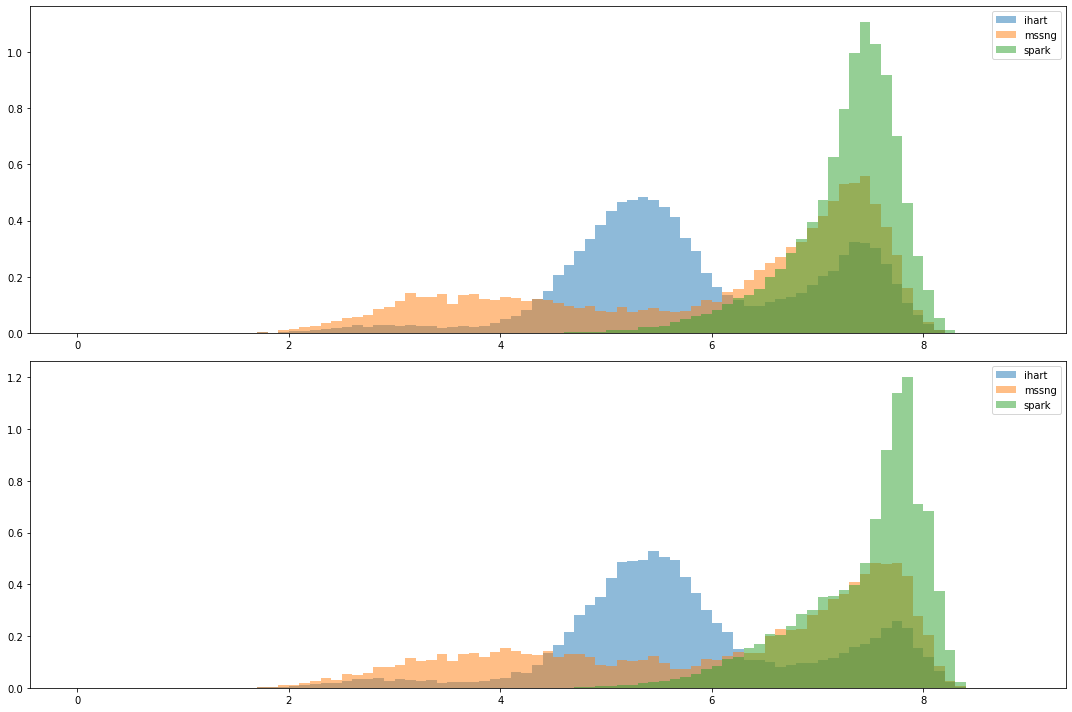

In [89]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
#plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('mssng', 0, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
#plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('mssng', 1, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 2, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True, label='ihart')
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('mssng', 2, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True, label='mssng')
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('spark', 2, 'mat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True, label='spark')
plt.legend()

plt.subplot(2, 1, 2)
#plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('mssng', 0, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
#plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('mssng', 1, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True)
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('ihart', 2, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True, label='ihart')
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('mssng', 2, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True, label='mssng')
plt.hist(np.log10(dataset_numaff_matpat_to_intervals[('spark', 2, 'pat')]), alpha=0.5, bins=np.arange(0, 9, 0.1), density=True, label='spark')
plt.legend()

plt.tight_layout()
plt.show()

In [220]:
#numaff_to_already_seen = defaultdict(set)


Complex = namedtuple('Complex', ['child1', 'child2', 'recomb1', 'recomb2', 'chrom', 'num_affected', 'is_mat'])
complexes = []

#dataset = 'spark'
#phase_dir = '../phased_spark_quads_del'
#ped_file = '../../DATA/spark/spark.ped'

#dataset = 'mssng'
#phase_dir = '../phased_mssng_quads_del'
#ped_file = '../../DATA/mssng/mssng.ped'

dataset = 'ihart'
phase_dir = '../phased_ihart.ms2_quads_del'
ped_file = '../../DATA/ihart.ms2/ihart.ped'

sample_to_affected, sample_to_sex, parents_to_children = pull_phenotype_ped(ped_file)
for file in sorted(os.listdir(phase_dir)):
    try:
        if file.endswith('.phased.txt'):
            family_id = file[:-11]
            print(family_id)
            individuals = pull_individuals('%s/%s.phased.txt' % (phase_dir, family_id))
            child1, child2 = individuals[2:]
            if child1 in sample_to_affected and child2 in sample_to_affected:
                num_affected = int(sample_to_affected[child1]=='2') + int(sample_to_affected[child2]=='2')

                if child1 not in numaff_to_already_seen[num_affected] and child2 not in numaff_to_already_seen[num_affected]:
                    numaff_to_already_seen[num_affected].add(child1)
                    numaff_to_already_seen[num_affected].add(child2)
                    
                    states, chroms, starts, ends, mat_indices, pat_indices = pull_phase('%s/%s.phased.txt' % (phase_dir, family_id))

                    #missing_chroms = set(range(1, 11)) - set(np.unique(chroms))
                    #if len(missing_chroms)>0:
                    #    raise RuntimeError('missing %s' % str(missing_chroms))

                    # start by pulling all recombinations
                    mat_recombinations = pull_recombinations(family_id, states, chroms, starts, ends, individuals, mat_indices, True)
                    for chrom, recombs in itertools.groupby(mat_recombinations, key=lambda x: x.chrom):
                        prev = next(recombs)
                        for recomb in recombs:
                            d = np.mean([recomb.start_pos, recomb.end_pos])-np.mean([prev.start_pos, prev.end_pos])
                            if d>10**4 and d<10**6:
                                complexes.append(Complex(child1, child2, prev, recomb, chrom, num_affected, True))
                            prev = recomb

                    pat_recombinations = pull_recombinations(family_id, states, chroms, starts, ends, individuals, pat_indices, False)
                    for chrom, recombs in itertools.groupby(pat_recombinations, key=lambda x: x.chrom):
                        prev = next(recombs)
                        for recomb in recombs:
                            d = np.mean([recomb.start_pos, recomb.end_pos])-np.mean([prev.start_pos, prev.end_pos])
                            if d>10**4 and d<10**6:
                                complexes.append(Complex(child1, child2, prev, recomb, chrom, num_affected, False))
                            prev = recomb
    except RuntimeError as e:
        print(e)
    except IndexError as e:
        print(e)
            
            

AU0001.AU000103.AU000104
This family contains identical twins.
AU0001.AU000103.AU000105
AU0001.AU000103.AU000106
AU0001.AU000104.AU000105
AU0001.AU000104.AU000106
AU0001.AU000105.AU000106
This family contains identical twins.
AU0012.AU001203.AU001204
AU0021.AU002103.AU002105
AU0021.AU002103.AU002106
AU0021.AU002105.AU002106
AU0022.AU002203.AU002204
AU0022.AU002203.AU002205
AU0022.AU002204.AU002205
AU0025.AU002503.AU002504
AU0025.AU0025311.AU0025312
AU0027.AU002703.AU002704
This family contains identical twins.
AU0028.AU002803.AU002804
AU0028.AU002803.AU002805
AU0028.AU002804.AU002805
AU0030.AU003003.AU003004
AU0030.AU003003.AU003005
AU0030.AU003004.AU003005
AU0033.AU003303.AU003304
AU0033.AU003303.AU003305
AU0033.AU003303.AU003306
AU0033.AU003304.AU003305
AU0033.AU003304.AU003306
AU0033.AU003305.AU003306
AU0037.AU003703.AU003704
AU0037.AU003703.AU003705
AU0037.AU003704.AU003705
AU0041.AU004103.AU004104
AU0041.AU004103.AU004105
AU0041.AU004104.AU004105
AU0043.AU004303.AU004304
AU0043.AU

KeyboardInterrupt: 

In [222]:
print(len(complexes))

613


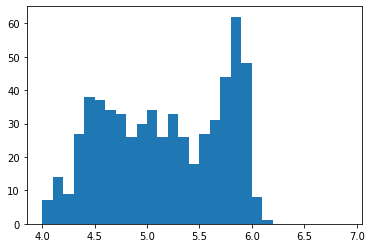

In [223]:
plt.hist([np.log10(x.recomb2.end_pos-x.recomb1.start_pos) for x in complexes], bins=np.arange(4, 7, 0.1))
plt.show()

In [224]:
positions = set()
sibpair_to_num_affected = dict()
for x in complexes:
    positions.add((x.chrom, x.recomb1.start_pos))
    positions.add((x.chrom, x.recomb2.end_pos))
    sibpair_to_num_affected[(x.child1, x.child2)] = x.num_affected

chrom_to_offset = dict()
offset = 0
for chrom in range(1, 23):
    positions.add((chrom, 1))
    positions.add((chrom, chrom_lengths38[str(chrom)]))
    chrom_to_offset[chrom] = offset
    offset += chrom_lengths38[str(chrom)]

sibpairs = sorted(sibpair_to_num_affected.keys())
sibpair_to_index = dict([(x, i) for i, x in enumerate(sibpairs)])    
positions = sorted(positions)
pos_to_index = dict([(x, i) for i, x in enumerate(positions)])

X_mat = np.zeros((len(positions), len(sibpairs)))
X_pat = np.zeros((len(positions), len(sibpairs)))
sibpair_mat, sibpair_pat = np.zeros((len(sibpairs),)), np.zeros((len(sibpairs),))
for x in complexes:
    sibpair_index = sibpair_to_index[(x.child1, x.child2)]
    if x.is_mat:
        X_mat[pos_to_index[(x.chrom, x.recomb1.start_pos)]:pos_to_index[(x.chrom, x.recomb2.end_pos)], sibpair_index] += 1
        sibpair_mat[sibpair_index] += 1
    else:
        X_pat[pos_to_index[(x.chrom, x.recomb1.start_pos)]:pos_to_index[(x.chrom, x.recomb2.end_pos)], sibpair_index] += 1
        sibpair_pat[sibpair_index] += 1


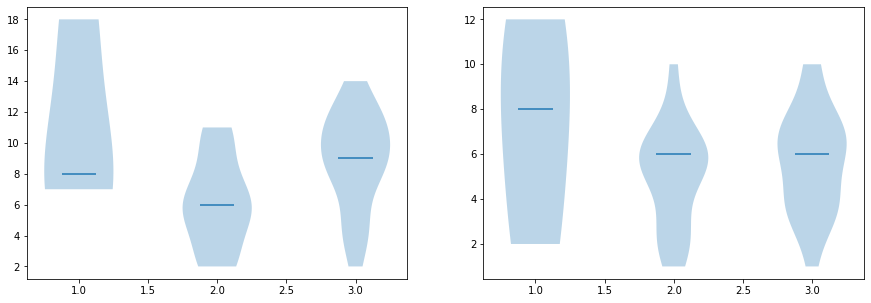

In [225]:
na = np.array([sibpair_to_num_affected[x] for x in sibpairs])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.violinplot([sibpair_mat[na==0], sibpair_mat[na==1], sibpair_mat[na==2]], 
               showmedians=True, showextrema=False)
plt.subplot(1, 2, 2)
plt.violinplot([sibpair_pat[na==0], sibpair_pat[na==1], sibpair_pat[na==2]], 
               showmedians=True, showextrema=False)
plt.show()

('AU0226303', 'AU0226301')
1
4 5


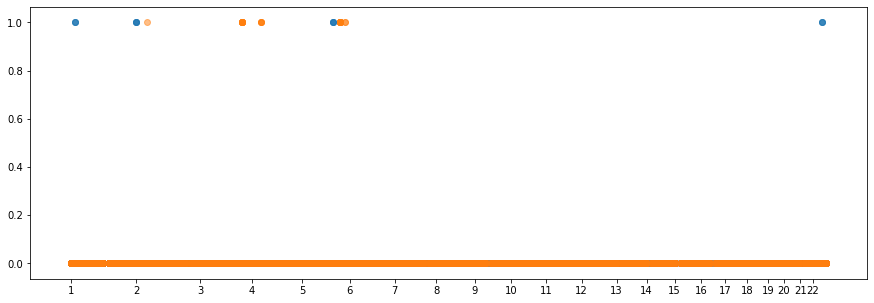

In [206]:
import random

index = random.choice(np.arange(len(sibpairs)))
print(sibpairs[index])
print(na[index])
print(len([x for x in complexes if x.child1==sibpairs[index][0] and x.child2==sibpairs[index][1] and x.is_mat]),
      len([x for x in complexes if x.child1==sibpairs[index][0] and x.child2==sibpairs[index][1] and not x.is_mat]))

plt.figure(figsize=(15, 5))
plt.scatter([chrom_to_offset[chrom]+pos for chrom, pos in positions], X_mat[:, index], alpha=0.5)
plt.scatter([chrom_to_offset[chrom]+pos for chrom, pos in positions], X_pat[:, index], alpha=0.5)
plt.xticks([chrom_to_offset[chrom] for chrom in range(1, 23)], [str(x) for x in range(1, 23)])
#plt.xlim([chrom_to_offset[15], chrom_to_offset[16]])
plt.show()

In [175]:
print([(x.chrom, x.recomb1.start_pos, x.recomb1.end_pos, x.recomb2.start_pos, x.recomb2.end_pos, x.is_mat) for x in complexes if x.child1==sibpairs[index][0] and x.child2==sibpairs[index][1]])



[(1, 10748766, 10749494, 10753618, 10782329, True), (4, 105084828, 105089276, 105467489, 105544642, True), (9, 41209819, 41231855, 41250273, 41297297, True), (14, 105576497, 106097099, 106252659, 106253266, True), (14, 106252659, 106253266, 106424210, 106427219, True), (14, 106424210, 106427219, 106557174, 106558224, True), (15, 30422728, 30445400, 30483799, 30484940, True), (15, 66668385, 66668624, 66960378, 66960975, True), (17, 36659522, 36662928, 36930715, 36952214, True), (3, 55315826, 55321635, 55767690, 55776791, False), (7, 80526486, 80530032, 81001551, 81037763, False), (8, 12134146, 12134679, 12159732, 12284933, False), (14, 105576497, 106097099, 106424794, 106424867, False), (14, 106424794, 106424867, 106557093, 106557174, False), (15, 66663760, 66668114, 66668385, 66686847, False)]


In [ ]:
print([x for x in complexe])